In [206]:
import mc_postgres_db.models as models
from sqlalchemy import select, alias
from sqlalchemy.orm import Session
import pandas as pd
import numpy as np
import datetime as dt
import requests
import matplotlib.pyplot as plt
from mc_postgres_db.prefect.asyncio.tasks import get_engine

engine = await get_engine()

23:01:30.685 | WARNING | prefect.client - Your Prefect server is running an older version of Prefect than your client which may result in unexpected behavior. Please upgrade your Prefect server from version 3.4.7 to version 3.4.10 or higher.

23:01:30.983 | INFO    | Task run 'get_engine' - Finished in state Completed()

In [207]:
import requests

response = requests.get("https://api.kraken.com/0/public/Assets")
assets = response.json()['result']
assets_df = pd.DataFrame([{
    "asset_code": asset_code,
    "name": asset['altname'],
    "decimals": asset['decimals'],
} for asset_code, asset in assets.items()])
assets_df

,asset_code,name,decimals
0,1INCH,1INCH,10
1,A,A,10
2,AAVE,AAVE,10
3,AB,AB,3
4,ACA,ACA,10
...,...,...,...
536,ZMXN,MXN,4
537,ZORA,ZORA,3
538,ZRO,ZRO,6
539,ZRX,ZRX,10


In [208]:
stmt = select(models.Asset)
assets_df = pd.read_sql(stmt, engine)
assets_df

,id,asset_type_id,name,description,symbol,underlying_asset_id,is_active,created_at,updated_at
0,1,1,BTC,Bitcoin,None,None,True,2025-06-18 00:29:01.302369,2025-06-18 00:29:01.302369
1,2,2,USD,US Dollar,None,None,True,2025-06-18 00:29:01.733709,2025-06-18 00:29:01.733709
2,3,1,ETH,Ethereum,None,None,True,2025-06-18 21:23:16.791629,2025-06-18 21:23:16.791629
3,4,1,XRP,Ripple,None,None,True,2025-06-24 03:28:57.160994,2025-06-24 03:28:57.160994
4,5,1,BNB,Binance Coin,None,None,True,2025-06-24 03:28:57.160994,2025-06-24 03:28:57.160994
5,7,1,SOL,Solana,None,None,True,2025-07-19 17:57:55.435722,2025-07-19 17:57:55.435722
6,8,1,AAVE,Aave Coin,None,None,True,2025-07-27 19:36:21.188398,2025-07-27 19:36:21.188398


In [209]:
from_asset = alias(models.Asset, name="from_asset")
to_asset = alias(models.Asset, name="to_asset")

provider_asset_market_df = pd.read_sql(
    select(
        models.ProviderAssetMarket.timestamp,
        from_asset.c.name.label("from_asset_name"),
        to_asset.c.name.label("to_asset_name"),
        models.ProviderAssetMarket.close,
    )
    .join(from_asset, models.ProviderAssetMarket.from_asset_id == from_asset.c.id)
    .join(to_asset, models.ProviderAssetMarket.to_asset_id == to_asset.c.id),
    engine,
)
provider_asset_market_df

,timestamp,from_asset_name,to_asset_name,close
0,2025-07-21 08:54:00,BTC,ETH,0.03171
1,2025-07-21 08:55:00,BTC,ETH,0.03171
2,2025-07-21 08:56:00,BTC,ETH,0.03173
3,2025-07-21 08:57:00,BTC,ETH,0.03173
4,2025-07-21 08:58:00,BTC,ETH,0.03173
...,...,...,...,...
69203,2025-07-30 21:56:00,USD,XRP,3.08184
69204,2025-07-30 21:57:00,USD,XRP,3.08093
69205,2025-07-30 21:58:00,USD,XRP,3.08003
69206,2025-07-30 21:59:00,USD,XRP,3.07906


In [210]:
window = "2h"  # 4-hour rolling window as a string
threshold = 0.005  # 0.5% deviation from mean

trade_signals = []

for (from_asset, to_asset), group in provider_asset_market_df.groupby(['from_asset_name', 'to_asset_name']):
    group = group.sort_values('timestamp').copy()
    group['timestamp'] = pd.to_datetime(group['timestamp'])  # Ensure datetime
    group = group.set_index('timestamp')
    group['rolling_mean'] = group['close'].rolling(window=window, min_periods=1).mean()
    group['deviation'] = (group['close'] - group['rolling_mean']) / group['rolling_mean']

    group['signal'] = 0
    group.loc[group['deviation'] < -threshold, 'signal'] = 1   # Buy
    group.loc[group['deviation'] > threshold, 'signal'] = -1   # Sell

    trades = group[group['signal'] != 0].reset_index()[['timestamp', 'from_asset_name', 'to_asset_name', 'close', 'signal']]
    trade_signals.append(trades)

all_trades = pd.concat(trade_signals).sort_values('timestamp').reset_index(drop=True)
all_trades['action'] = all_trades['signal'].map({1: 'buy', -1: 'sell'})

display(all_trades)

,timestamp,from_asset_name,to_asset_name,close,signal,action
0,2025-07-21 10:39:00,BTC,ETH,0.031960,-1,sell
1,2025-07-21 10:40:00,BTC,ETH,0.031990,-1,sell
2,2025-07-21 10:41:00,BTC,ETH,0.031990,-1,sell
3,2025-07-21 10:42:00,BTC,ETH,0.032010,-1,sell
4,2025-07-21 10:43:00,USD,ETH,3798.070000,-1,sell
...,...,...,...,...,...,...
14597,2025-07-30 21:59:00,USD,AAVE,271.360000,1,buy
14598,2025-07-30 22:00:00,ETH,AAVE,0.072100,1,buy
14599,2025-07-30 22:00:00,USD,AAVE,271.360000,1,buy
14600,2025-07-30 22:00:00,BTC,AAVE,0.002307,1,buy


In [211]:
# Simple simulation of taking action on the trades

initial_capital = 10000  # starting amount in from_asset for each pair
portfolio = {}

# We'll track results for each pair
results = []

for (from_asset, to_asset), trades in all_trades.groupby(['from_asset_name', 'to_asset_name']):
    cash = initial_capital
    position = 0  # amount of to_asset held
    trade_history = []
    
    for idx, row in trades.iterrows():
        price = row['close']
        action = row['action']
        timestamp = row['timestamp']
        
        if action == 'buy' and cash > 0:
            # Buy as much as possible with available cash
            qty = cash / price
            position += qty
            cash = 0
            trade_history.append((timestamp, 'buy', qty, price))
        elif action == 'sell' and position > 0:
            # Sell all held position
            cash += position * price
            trade_history.append((timestamp, 'sell', position, price))
            position = 0
    
    # Calculate final portfolio value
    final_value = cash + position * trades.iloc[-1]['close']
    results.append({
        'pair': f"{from_asset}/{to_asset}",
        'final_value': final_value,
        'return_%': 100 * (final_value - initial_capital) / initial_capital,
        'trades': trade_history
    })

# Display results
results_df = pd.DataFrame(results)
display(results_df)

# Compute total return across all pairs
total_initial = initial_capital * len(results_df)
total_final = results_df['final_value'].sum()
total_return_pct = 100 * (total_final - total_initial) / total_initial

print(f"Total initial capital: {total_initial:.2f}")
print(f"Total final value: {total_final:.2f}")
print(f"Total return: {total_return_pct:.2f}%")

,pair,final_value,return_%,trades
0,BTC/AAVE,9794.374407,-2.056256,"[(2025-07-27 14:49:00, buy, 4003202.56204964, ..."
1,BTC/ETH,10028.805779,0.288058,"[(2025-07-21 13:13:00, buy, 312207.3056509522,..."
2,BTC/XRP,9792.737582,-2.072624,"[(2025-07-28 01:34:00, buy, 369003690.03690034..."
3,ETH/AAVE,9509.597023,-4.904030,"[(2025-07-27 10:41:00, buy, 128369.70474967908..."
4,ETH/XRP,10202.510274,2.025103,"[(2025-07-28 01:31:00, buy, 11916110.581506196..."
5,USD/AAVE,9727.212072,-2.727879,"[(2025-07-27 12:40:00, buy, 33.87878171900938,..."
6,USD/BTC,10503.249672,5.032497,"[(2025-07-21 12:02:00, buy, 0.0847816871555744..."
7,USD/ETH,10476.516611,4.765166,"[(2025-07-21 13:05:00, buy, 2.6383901598600596..."
8,USD/XRP,9863.339465,-1.366605,"[(2025-07-28 01:31:00, buy, 3091.486355724969,..."


Total initial capital: 90000.00
Total final value: 89898.34
Total return: -0.11%


## Geometric Brownian Motion

The following is the equation for geometric brownian motion:

$$
\frac{\Delta S}{S} = \mu \Delta t + \sigma \epsilon \sqrt{\Delta t}
$$

Where:
$$
S = \text{the stock price}
$$
$$
\Delta S = \text{the change in stock price}
$$
$$
\mu = \text{the expected return} 
$$
$$
\sigma = \text{the standard deviation of returns}
$$
$$
\epsilon = \text{the random variable} 
$$
$$
\Delta t = \text{the elapsed time period}
$$
Re-aranging the equation we get:
$$
\Delta S = S \times (\mu \Delta t + \sigma \epsilon \sqrt{\Delta t})
$$
So we can model different trials by calculating $\Delta S$ at each time step, calculating the next price like the following:
$$
S_{t} = S_{t-1} + S_{t-1} \times (\mu \Delta t + \sigma \epsilon \sqrt{\Delta t})
$$
Simplifying:
$$
S_{t} = S_{t-1} (1 + (\mu \Delta t + \sigma \epsilon \sqrt{\Delta t}))
$$

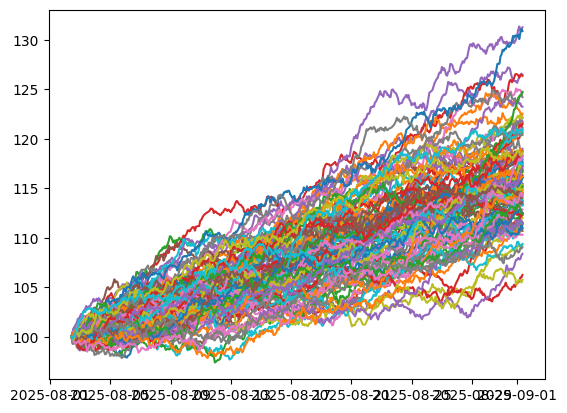

In [283]:
from tqdm.notebook import tqdm
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

mu = np.linspace(-0.5, 0.5, 2)
N_mu = len(mu)
N_sims = 100
N_days = 30

start = dt.datetime.now()
end = start + dt.timedelta(days=N_days)
T = np.arange(start, end, np.timedelta64(1, '1m'))

S_0 = 100
epsilon = np.random.uniform(-1, 1, (N_sims, len(T)))
sigma = np.ones((N_sims, len(T))) * 0.075
delta_t = np.ones((N_sims, len(T))) * (1 / len(T))
mu = np.ones((N_sims, len(T))) * 0.15
S = S_0 * np.cumprod(1 + mu * delta_t + sigma * epsilon * np.sqrt(delta_t), axis=1)

for i in range(N_sims):
    time_stride = 100
    T_subset = T[::time_stride]
    S_subset = S[i, ::time_stride]
    plt.plot(T_subset, S_subset)
plt.show()

In [216]:
S.shape

(1000, 43200)

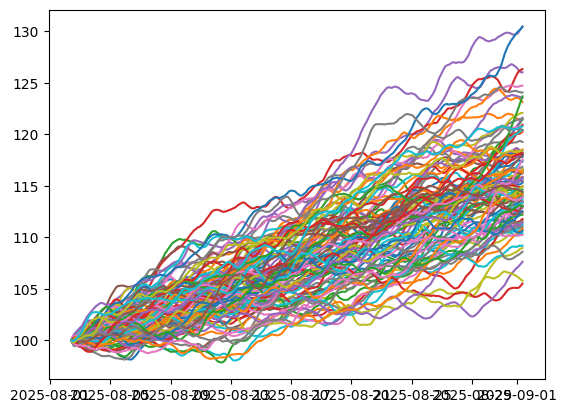

In [284]:
# Create kernel for convolution
window = 1000
kernel = np.ones(window) / window

# Apply convolution to each row
result = np.apply_along_axis(
    lambda x: np.convolve(x, kernel, mode='valid'), 
    axis=1, 
    arr=S
)
S_means = np.full_like(S, np.nan)
S_means[:, window-1:] = result

# Fill the beginning with expanding means
for i in range(S.shape[0]):  # For each row
    for j in range(window-1):  # For each position before full window
        if j == 0:
            # First position: just the first value
            S_means[i, j] = S[i, j]
        else:
            # Other positions: mean of all available data points
            S_means[i, j] = np.mean(S[i, :j+1])
        
# Plot
for i in range(N_sims):
    time_stride = 100
    T_subset = T[::time_stride]
    S_means_subset = S_means[i, ::time_stride]
    plt.plot(T_subset, S_means_subset)
plt.show()

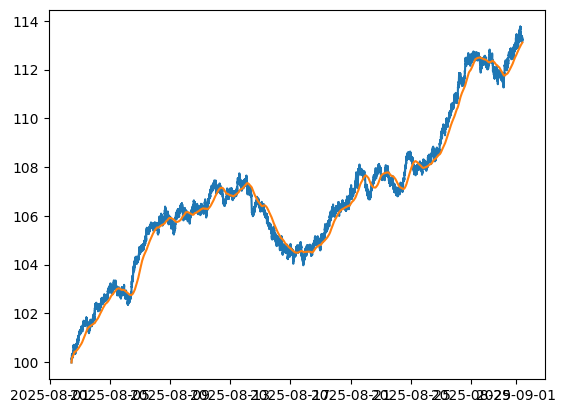

In [285]:
plt.plot(T, S[0, :])
plt.plot(T, S_means[0, :])
plt.show()

In [1]:
(S - S_means) / S_means

NameError: name 'S' is not defined

In [ ]:
np.abs(S - S_means) / S_means

array([[0.00000000e+00, 1.36431062e-04, 1.09860943e-04, ...,
        1.14911070e-03, 1.34572829e-03, 1.29614306e-03],
       [0.00000000e+00, 3.88835185e-05, 9.94257584e-05, ...,
        4.09279693e-04, 3.73244446e-04, 5.79497476e-05],
       [0.00000000e+00, 9.92166158e-05, 2.28280244e-05, ...,
        1.05082766e-03, 8.96506773e-04, 6.39973789e-04],
       ...,
       [0.00000000e+00, 2.81120063e-05, 9.92106402e-05, ...,
        4.16736540e-03, 3.98514809e-03, 3.89041090e-03],
       [0.00000000e+00, 1.47658636e-04, 6.22254842e-05, ...,
        3.53349271e-03, 3.78227380e-03, 4.06744638e-03],
       [0.00000000e+00, 3.03221188e-05, 1.72785871e-04, ...,
        1.81931016e-03, 1.76668695e-03, 1.92888753e-03]],
      shape=(100, 43200))

In [286]:
threshold = 0.01
S_signals = (np.abs(S - S_means) / S_means) > threshold
S_signals

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(100, 43200))

In [274]:
S_buys = S_signals & (S < S_means)
S_sells = S_signals & (S > S_means)

In [280]:
# Initialize arrays
initial_capital = 10000.0
cash = np.full((N_sims, len(T)), initial_capital)
position = np.zeros((N_sims, len(T)))
holding = np.zeros((N_sims, len(T)), dtype=bool)

# Create position constraint masks
# Can only buy if not holding
valid_buys = S_buys & ~holding

# Can only sell if holding
valid_sells = S_sells & holding

# Execute buy orders (vectorized across all time steps)
buy_amounts = np.where(valid_buys, cash, 0)
position += buy_amounts / S
cash -= buy_amounts

# Execute sell orders (vectorized across all time steps)
sell_amounts = np.where(valid_sells, position * S, 0)
cash += sell_amounts
position = np.where(valid_sells, 0, position)

# Update holding status
holding = position > 0

# Calculate portfolio values
portfolio_values = cash + position * S

In [281]:
portfolio_values[: , -1]

array([10000., 10000., 10000., ..., 10000., 10000., 10000.],
      shape=(10000,))

In [270]:
np.mean(S[:, -1])

np.float64(115.98060502598595)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


def get_signal(series: pd.Series) -> pd.Series:
    X = np.arange(len(series)).reshape(-1, 1)
    y = series.values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    return model.predict(X[-1:])[0][0]

get_signal(pd.Series(np.arange(10)))

np.float64(9.0)

In [117]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import numpy as np

endog = S[0, 0, :]
exog = sm.add_constant(np.arange(len(T)).reshape(-1, 1))
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
params = rres.params.copy()
params.index = np.arange(1, params.shape[0] + 1)
params.head()


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [123]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def ensemble_mean_reversion(df: pd.DataFrame, window=100):
    """
    Combine multiple ML models for mean reversion signals
    """
    # Create features
    df['rolling_mean'] = df['close'].rolling(window=window).mean()
    df['rolling_std'] = df['close'].rolling(window=window).std()
    df['deviation'] = (df['close'] - df['rolling_mean']) / df['rolling_std']
    df['momentum'] = df['close'].pct_change(5)
    df['volatility'] = df['close'].rolling(20).std()
    df['rsi'] = calculate_rsi(df['close'], 14)
    df['macd'] = calculate_macd(df['close'])
    
    # Target: future mean reversion
    df['future_return'] = df['close'].shift(-1) / df['close'] - 1
    
    df = df.dropna()
    
    features = ['deviation', 'momentum', 'volatility', 'rsi', 'macd', 'rolling_std']
    X = df[features]
    y = df['future_return']
    
    # Create ensemble model
    models = [
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
        ('svr', SVR(kernel='rbf')),
        ('lr', LinearRegression())
    ]
    
    ensemble = VotingRegressor(models)
    ensemble.fit(X[:-1], y[:-1])
    
    # Generate predictions
    predictions = ensemble.predict(X)
    
    # Create ensemble signals
    df['ensemble_prediction'] = predictions
    df['ensemble_signal'] = 0
    df.loc[predictions > 0.015, 'ensemble_signal'] = 1
    df.loc[predictions < -0.015, 'ensemble_signal'] = -1
    
    return df

def calculate_rsi(prices, window=14):
    """Calculate RSI indicator"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD indicator"""
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal).mean()
    return macd - signal_line

In [127]:
import pandas as pd

df = pd.DataFrame({
    "close": pd.Series(S[0, 0, :])
})

df = ensemble_mean_reversion(df)
df

/var/folders/tc/qpkxsjrx4s72nqyhf67_1ctw0000gn/T/ipykernel_77497/3027684185.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ensemble_prediction'] = predictions
/var/folders/tc/qpkxsjrx4s72nqyhf67_1ctw0000gn/T/ipykernel_77497/3027684185.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ensemble_signal'] = 0


,close,rolling_mean,rolling_std,deviation,momentum,volatility,rsi,macd,future_return,ensemble_prediction,ensemble_signal
99,105.833441,104.136119,2.008623,0.845018,-0.004458,0.351020,41.645202,-0.116366,0.000721,0.000338,0
100,105.909747,104.195216,1.972312,0.869300,-0.001900,0.361018,36.930005,-0.120866,-0.001461,-0.000484,0
101,105.754974,104.252507,1.932793,0.777356,-0.003472,0.381502,30.441755,-0.128978,-0.001493,-0.000415,0
102,105.597033,104.305525,1.895500,0.681355,-0.004725,0.416736,18.020614,-0.138836,0.000437,0.000197,0
103,105.643180,104.357244,1.860052,0.691344,-0.006412,0.443127,16.284370,-0.135937,-0.001331,-0.000175,0
...,...,...,...,...,...,...,...,...,...,...,...
10074,42.409602,42.122978,0.575850,0.497740,0.000326,0.096939,47.621008,0.007086,0.001437,0.000222,0
10075,42.470527,42.131762,0.574368,0.589804,-0.004022,0.093389,52.019393,0.009586,-0.002887,-0.001035,0
10076,42.347928,42.138160,0.573163,0.365982,-0.003343,0.087595,52.727586,0.003271,0.002608,0.000627,0
10077,42.458391,42.145707,0.572353,0.546313,0.000589,0.080429,53.647929,0.006628,0.002961,0.001071,0


In [129]:
df.loc[df["ensemble_signal"] == 0]

,close,rolling_mean,rolling_std,deviation,momentum,volatility,rsi,macd,future_return,ensemble_prediction,ensemble_signal
99,105.833441,104.136119,2.008623,0.845018,-0.004458,0.351020,41.645202,-0.116366,0.000721,0.000338,0
100,105.909747,104.195216,1.972312,0.869300,-0.001900,0.361018,36.930005,-0.120866,-0.001461,-0.000484,0
101,105.754974,104.252507,1.932793,0.777356,-0.003472,0.381502,30.441755,-0.128978,-0.001493,-0.000415,0
102,105.597033,104.305525,1.895500,0.681355,-0.004725,0.416736,18.020614,-0.138836,0.000437,0.000197,0
103,105.643180,104.357244,1.860052,0.691344,-0.006412,0.443127,16.284370,-0.135937,-0.001331,-0.000175,0
...,...,...,...,...,...,...,...,...,...,...,...
10074,42.409602,42.122978,0.575850,0.497740,0.000326,0.096939,47.621008,0.007086,0.001437,0.000222,0
10075,42.470527,42.131762,0.574368,0.589804,-0.004022,0.093389,52.019393,0.009586,-0.002887,-0.001035,0
10076,42.347928,42.138160,0.573163,0.365982,-0.003343,0.087595,52.727586,0.003271,0.002608,0.000627,0
10077,42.458391,42.145707,0.572353,0.546313,0.000589,0.080429,53.647929,0.006628,0.002961,0.001071,0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [103]:
S.shape

(20, 5, 43200)

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

window = "4h"
df = pd.DataFrame({ "timestamp": T, "close" : pd.Series(S[0, 0, :])})
df = df.set_index('timestamp')
df["linear_pred"] = df["close"].rolling(window=window, min_periods=1).apply(lambda series: get_signal(series))
df["deviation"] = (df["linear_pred"] - df["close"]) / df["linear_pred"]
df["signal"] = 0
df.loc[df["deviation"] < -threshold, "signal"] = 1   # Buy
df.loc[df["deviation"] > threshold, "signal"] = -1   # Sell

In [104]:
df["deviation"] = (df["linear_pred"] - df["close"]) / df["linear_pred"]
df["signal"] = 0
df.loc[df["deviation"] < -threshold, "signal"] = 1   # Buy
df.loc[df["deviation"] > threshold, "signal"] = -1   # Sell

In [ ]:
df

In [105]:
df.loc[df["signal"] == -1]

,close,linear_pred,deviation,signal
timestamp,,,,
2025-07-29 22:29:19.254643,99.455136,100.103495,0.006477,-1
2025-07-29 22:30:19.254643,99.430129,100.091270,0.006605,-1
2025-07-29 22:31:19.254643,99.446223,100.079678,0.006330,-1
2025-07-29 22:32:19.254643,99.234619,100.063264,0.008281,-1
2025-07-29 22:33:19.254643,99.212886,100.046664,0.008334,-1
...,...,...,...,...
2025-08-28 19:32:19.254643,115.673062,116.525752,0.007318,-1
2025-08-28 19:33:19.254643,115.584080,116.483304,0.007720,-1
2025-08-28 19:34:19.254643,115.646380,116.443257,0.006843,-1


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


=== SIMULATION RESULTS ===
Number of simulations: 10
Number of mu values: 5
Initial capital per simulation: $10,000.00
Strategy parameters: 4h window, 0.5% threshold

=== FINAL RETURNS (%) ===
Mean: 1.29%
Std: 23.57%
Min: -57.54%
Max: 62.26%
Median: -3.75%

=== FINAL PORTFOLIO VALUES ===
Mean: $10,129.14
Std: $2,356.89
Min: $4,245.85
Max: $16,226.33
Median: $9,625.03


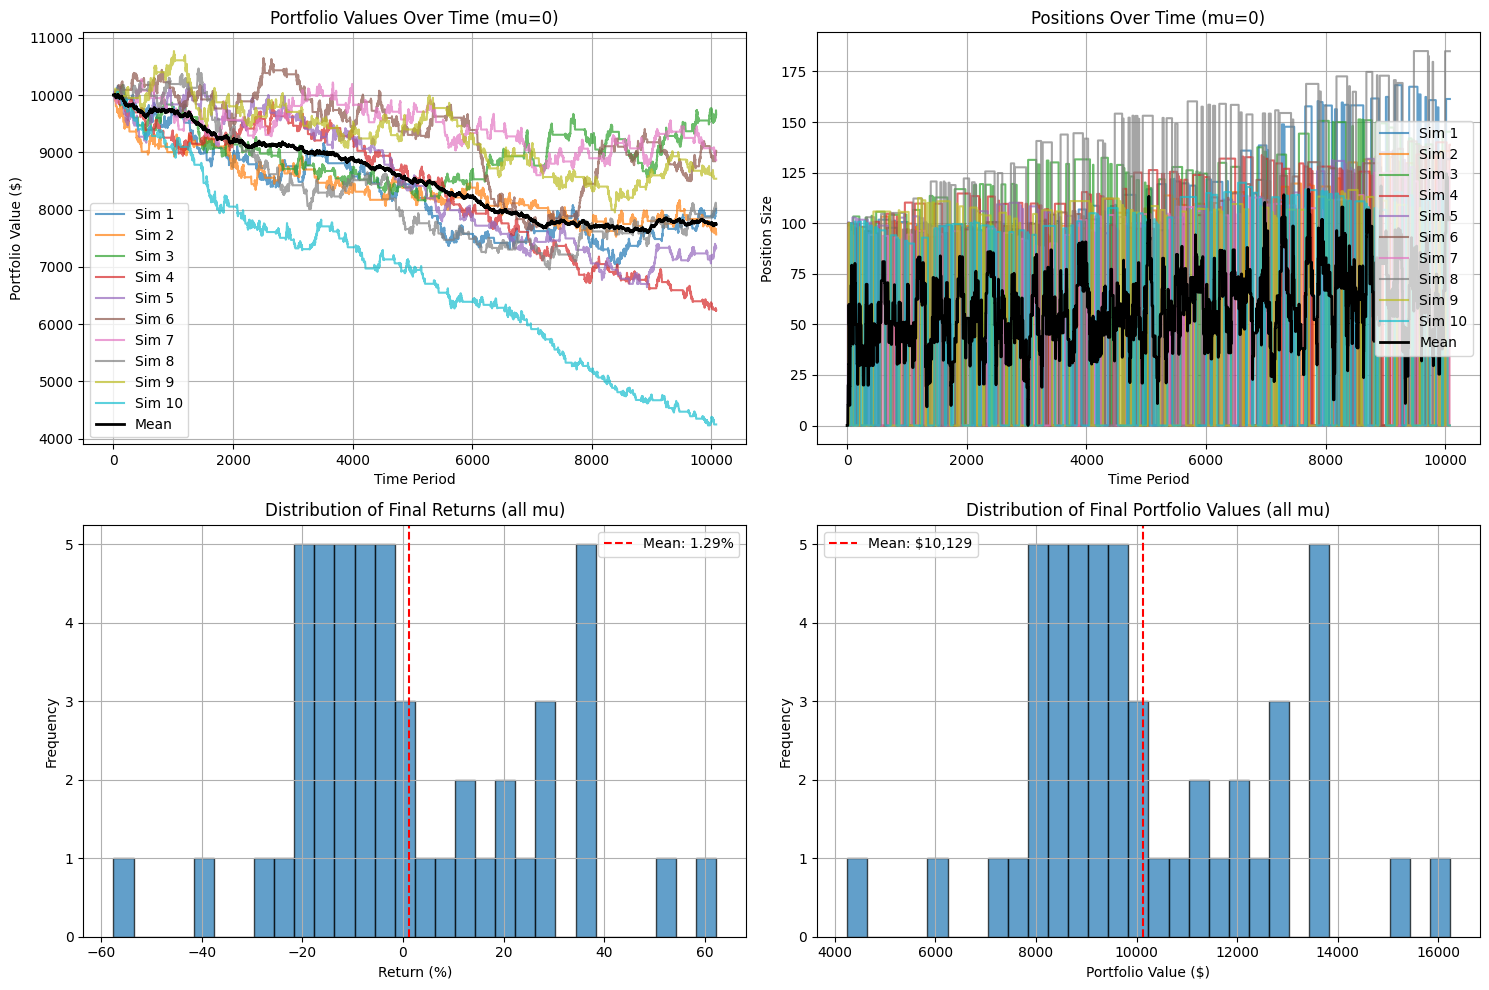


=== DETAILED RESULTS ===
Best performing simulation: sim=3, mu=4 (Return: 62.26%)
Worst performing simulation: sim=9, mu=0 (Return: -57.54%)
Probability of positive return: 42.0%


In [110]:
import numpy as np
import pandas as pd

# Parameters
window = "4h"  # 4-hour rolling window
threshold = 0.005  # 0.5% deviation from mean
initial_capital = 10000

# Initialize tracking arrays
N_sim = S.shape[0]  # number of simulations (0th index)
N_mu = S.shape[1]   # number of mu values (1st index)
N_time = S.shape[2]  # number of time periods (2nd index)
final_returns = np.zeros((N_sim, N_mu))
final_portfolio_values = np.zeros((N_sim, N_mu))
portfolio_values_over_time = np.zeros((N_time, N_sim, N_mu))
positions_over_time = np.zeros((N_time, N_sim, N_mu))

# For each simulation and each mu
for sim_idx in tqdm(range(N_sim)):
    for mu_idx in tqdm(range(N_mu), leave=False):
        # print(f"Processing simulation {sim_idx + 1}/{N_sim}, mu {mu_idx + 1}/{N_mu}")
        
        # Get simulated prices for this simulation and mu
        simulated_prices = S[sim_idx, mu_idx, :]
        
        # Create a DataFrame with simulated prices and timestamps
        sim_df = pd.DataFrame({
            'timestamp': pd.date_range(start='2025-01-01', periods=N_time, freq='1min'),
            'close': simulated_prices
        })
        
        # Apply mean reversion strategy
        sim_df = sim_df.sort_values('timestamp').copy()
        sim_df['timestamp'] = pd.to_datetime(sim_df['timestamp'])
        sim_df = sim_df.set_index('timestamp')
        sim_df["linear_pred"] = sim_df["close"].rolling(window=window, min_periods=1).apply(lambda series: get_signal(series))
        sim_df["deviation"] = (sim_df["linear_pred"] - sim_df["close"]) / sim_df["linear_pred"]
        
        # Generate signals
        sim_df['signal'] = 0
        sim_df.loc[sim_df['deviation'] < -threshold, 'signal'] = 1   # Buy
        sim_df.loc[sim_df['deviation'] > threshold, 'signal'] = -1   # Sell
        
        # Initialize portfolio tracking
        cash = initial_capital
        position = 0
        current_portfolio_value = initial_capital
        
        # Track portfolio over time
        for t in range(N_time):
            current_price = simulated_prices[t]
            
            # Execute trades based on signals
            if t > 0:  # Skip first period for signal generation
                signal = sim_df.iloc[t-1]['signal']  # Use previous period's signal
                
                if signal == 1 and cash > 0:  # Buy signal
                    qty = cash / current_price
                    position += qty
                    cash = 0
                elif signal == -1 and position > 0:  # Sell signal
                    cash += position * current_price
                    position = 0
            
            # Calculate current portfolio value
            current_portfolio_value = cash + position * current_price
            
            # Store values
            portfolio_values_over_time[t, sim_idx, mu_idx] = current_portfolio_value
            positions_over_time[t, sim_idx, mu_idx] = position
        
        # Store final results
        final_portfolio_values[sim_idx, mu_idx] = current_portfolio_value
        final_returns[sim_idx, mu_idx] = 100 * (current_portfolio_value - initial_capital) / initial_capital

# Create summary statistics
summary_stats = {
    'Final Returns (%)': {
        'Mean': np.mean(final_returns),
        'Std': np.std(final_returns),
        'Min': np.min(final_returns),
        'Max': np.max(final_returns),
        'Median': np.median(final_returns)
    },
    'Final Portfolio Values': {
        'Mean': np.mean(final_portfolio_values),
        'Std': np.std(final_portfolio_values),
        'Min': np.min(final_portfolio_values),
        'Max': np.max(final_portfolio_values),
        'Median': np.median(final_portfolio_values)
    }
}

# Display results
print("\n=== SIMULATION RESULTS ===")
print(f"Number of simulations: {N_sim}")
print(f"Number of mu values: {N_mu}")
print(f"Initial capital per simulation: ${initial_capital:,.2f}")
print(f"Strategy parameters: {window} window, {threshold*100:.1f}% threshold")

print("\n=== FINAL RETURNS (%) ===")
for stat, value in summary_stats['Final Returns (%)'].items():
    print(f"{stat}: {value:.2f}%")

print("\n=== FINAL PORTFOLIO VALUES ===")
for stat, value in summary_stats['Final Portfolio Values'].items():
    print(f"{stat}: ${value:,.2f}")

# Create time series plots (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Plot 1: Portfolio values over time (first mu value, first 10 simulations)
plt.subplot(2, 2, 1)
for sim_idx in range(min(10, N_sim)):  # Plot first 10 simulations for mu_idx=0
    plt.plot(portfolio_values_over_time[:, sim_idx, 0], alpha=0.7, label=f'Sim {sim_idx+1}')
plt.plot(np.mean(portfolio_values_over_time[:, :, 0], axis=1), 'k-', linewidth=2, label='Mean')
plt.title('Portfolio Values Over Time (mu=0)')
plt.xlabel('Time Period')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)

# Plot 2: Positions over time (first mu value, first 10 simulations)
plt.subplot(2, 2, 2)
for sim_idx in range(min(10, N_sim)):
    plt.plot(positions_over_time[:, sim_idx, 0], alpha=0.7, label=f'Sim {sim_idx+1}')
plt.plot(np.mean(positions_over_time[:, :, 0], axis=1), 'k-', linewidth=2, label='Mean')
plt.title('Positions Over Time (mu=0)')
plt.xlabel('Time Period')
plt.ylabel('Position Size')
plt.legend()
plt.grid(True)

# Plot 3: Final returns distribution (all mu and sim)
plt.subplot(2, 2, 3)
plt.hist(final_returns.flatten(), bins=30, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(final_returns), color='red', linestyle='--', label=f'Mean: {np.mean(final_returns):.2f}%')
plt.title('Distribution of Final Returns (all mu)')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Plot 4: Final portfolio values distribution (all mu and sim)
plt.subplot(2, 2, 4)
plt.hist(final_portfolio_values.flatten(), bins=30, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(final_portfolio_values), color='red', linestyle='--', 
           label=f'Mean: ${np.mean(final_portfolio_values):,.0f}')
plt.title('Distribution of Final Portfolio Values (all mu)')
plt.xlabel('Portfolio Value ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save results to DataFrame for further analysis
results_df = pd.DataFrame({
    'simulation': np.repeat(np.arange(N_sim), N_mu),
    'mu_idx': np.tile(np.arange(N_mu), N_sim),
    'final_return_pct': final_returns.flatten(),
    'final_portfolio_value': final_portfolio_values.flatten()
})

print(f"\n=== DETAILED RESULTS ===")
best_idx = np.unravel_index(np.argmax(final_returns), final_returns.shape)
worst_idx = np.unravel_index(np.argmin(final_returns), final_returns.shape)
print(f"Best performing simulation: sim={best_idx[0]}, mu={best_idx[1]} (Return: {final_returns[best_idx]:.2f}%)")
print(f"Worst performing simulation: sim={worst_idx[0]}, mu={worst_idx[1]} (Return: {final_returns[worst_idx]:.2f}%)")
print(f"Probability of positive return: {np.mean(final_returns > 0)*100:.1f}%")

In [ ]:
import numpy as np
import pandas as pd

# Parameters
initial_capital = 10000

# Initialize tracking arrays
N_sim = S.shape[0]  # number of simulations (0th index)
N_time = S.shape[1]  # number of time periods (1st index)
final_returns_bh = np.zeros(N_sim)
final_portfolio_values_bh = np.zeros(N_sim)
portfolio_values_over_time_bh = np.zeros((N_time, N_sim))
positions_over_time_bh = np.zeros((N_time, N_sim))

# For each simulation
for sim_idx in range(N_sim):
    print(f"Processing Buy & Hold simulation {sim_idx + 1}/{N_sim}")
    
    # Get simulated prices for this simulation
    simulated_prices = S[sim_idx, :]  # Fixed: use 0th index for sims
    
    # Buy and Hold Strategy: Buy at first price, hold until end
    first_price = simulated_prices[0]
    last_price = simulated_prices[-1]
    
    # Buy as much as possible with initial capital
    initial_position = initial_capital / first_price
    cash = 0  # All cash used for initial purchase
    
    # Track portfolio over time
    for t in range(N_time):
        current_price = simulated_prices[t]
        
        # In buy and hold, position stays constant
        current_position = initial_position
        current_portfolio_value = current_position * current_price
        
        # Store values
        portfolio_values_over_time_bh[t, sim_idx] = current_portfolio_value
        positions_over_time_bh[t, sim_idx] = current_position
    
    # Store final results
    final_portfolio_values_bh[sim_idx] = current_portfolio_value
    final_returns_bh[sim_idx] = 100 * (current_portfolio_value - initial_capital) / initial_capital

# Create summary statistics for Buy & Hold
summary_stats_bh = {
    'Final Returns (%)': {
        'Mean': np.mean(final_returns_bh),
        'Std': np.std(final_returns_bh),
        'Min': np.min(final_returns_bh),
        'Max': np.max(final_returns_bh),
        'Median': np.median(final_returns_bh)
    },
    'Final Portfolio Values': {
        'Mean': np.mean(final_portfolio_values_bh),
        'Std': np.std(final_portfolio_values_bh),
        'Min': np.min(final_portfolio_values_bh),
        'Max': np.max(final_portfolio_values_bh),
        'Median': np.median(final_portfolio_values_bh)
    }
}

# Display results
print("\n=== BUY & HOLD SIMULATION RESULTS ===")
print(f"Number of simulations: {N_sim}")
print(f"Initial capital per simulation: ${initial_capital:,.2f}")

print("\n=== FINAL RETURNS (%) ===")
for stat, value in summary_stats_bh['Final Returns (%)'].items():
    print(f"{stat}: {value:.2f}%")

print("\n=== FINAL PORTFOLIO VALUES ===")
for stat, value in summary_stats_bh['Final Portfolio Values'].items():
    print(f"{stat}: ${value:,.2f}")

# Create time series plots for Buy & Hold
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Plot 1: Portfolio values over time
plt.subplot(2, 2, 1)
for sim_idx in range(min(10, N_sim)):  # Plot first 10 simulations
    plt.plot(portfolio_values_over_time_bh[:, sim_idx], alpha=0.7, label=f'Sim {sim_idx+1}')
plt.plot(np.mean(portfolio_values_over_time_bh, axis=1), 'k-', linewidth=2, label='Mean')
plt.title('Buy & Hold: Portfolio Values Over Time')
plt.xlabel('Time Period')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)

# Plot 2: Positions over time
plt.subplot(2, 2, 2)
for sim_idx in range(min(10, N_sim)):
    plt.plot(positions_over_time_bh[:, sim_idx], alpha=0.7, label=f'Sim {sim_idx+1}')
plt.plot(np.mean(positions_over_time_bh, axis=1), 'k-', linewidth=2, label='Mean')
plt.title('Buy & Hold: Positions Over Time')
plt.xlabel('Time Period')
plt.ylabel('Position Size')
plt.legend()
plt.grid(True)

# Plot 3: Final returns distribution
plt.subplot(2, 2, 3)
plt.hist(final_returns_bh, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(final_returns_bh), color='red', linestyle='--', label=f'Mean: {np.mean(final_returns_bh):.2f}%')
plt.title('Buy & Hold: Distribution of Final Returns')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Plot 4: Final portfolio values distribution
plt.subplot(2, 2, 4)
plt.hist(final_portfolio_values_bh, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(final_portfolio_values_bh), color='red', linestyle='--', 
           label=f'Mean: ${np.mean(final_portfolio_values_bh):,.0f}')
plt.title('Buy & Hold: Distribution of Final Portfolio Values')
plt.xlabel('Portfolio Value ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save results to DataFrame for further analysis
results_df_bh = pd.DataFrame({
    'simulation': range(N_sim),
    'final_return_pct': final_returns_bh,
    'final_portfolio_value': final_portfolio_values_bh
})

print(f"\n=== BUY & HOLD DETAILED RESULTS ===")
print(f"Best performing simulation: {np.argmax(final_returns_bh)} (Return: {np.max(final_returns_bh):.2f}%)")
print(f"Worst performing simulation: {np.argmin(final_returns_bh)} (Return: {np.min(final_returns_bh):.2f}%)")
print(f"Probability of positive return: {np.mean(final_returns_bh > 0)*100:.1f}%")

# Compare strategies if you have the mean reversion results
if 'final_returns' in locals():
    print(f"\n=== STRATEGY COMPARISON ===")
    print(f"Mean Reversion vs Buy & Hold:")
    print(f"Mean Return: {np.mean(final_returns):.2f}% vs {np.mean(final_returns_bh):.2f}%")
    print(f"Return Std Dev: {np.std(final_returns):.2f}% vs {np.std(final_returns_bh):.2f}%")
    print(f"Min Return: {np.min(final_returns):.2f}% vs {np.min(final_returns_bh):.2f}%")
    print(f"Max Return: {np.max(final_returns):.2f}% vs {np.max(final_returns_bh):.2f}%")
    print(f"Probability of positive return: {np.mean(final_returns > 0)*100:.1f}% vs {np.mean(final_returns_bh > 0)*100:.1f}%")
    
    # Calculate strategy outperformance
    outperformance = final_returns - final_returns_bh
    print(f"Mean Reversion outperformance: {np.mean(outperformance):.2f}%")
    print(f"Probability Mean Reversion beats Buy & Hold: {np.mean(outperformance > 0)*100:.1f}%")

In [ ]:
# Buy and Hold simulation for each pair
buyhold_results = []

for (from_asset, to_asset), group in provider_asset_market_df.groupby(['from_asset_name', 'to_asset_name']):
    group = group.sort_values('timestamp')
    if group.empty:
        continue
    first_price = group.iloc[0]['close']
    last_price = group.iloc[-1]['close']
    qty = initial_capital / first_price
    final_value = qty * last_price
    buyhold_results.append({
        'pair': f"{from_asset}/{to_asset}",
        'final_value': final_value,
        'return_%': 100 * (final_value - initial_capital) / initial_capital
    })

buyhold_df = pd.DataFrame(buyhold_results)
display(buyhold_df)

# Compute total return for buy and hold
total_bh_initial = initial_capital * len(buyhold_df)
total_bh_final = buyhold_df['final_value'].sum()
total_bh_return_pct = 100 * (total_bh_final - total_bh_initial) / total_bh_initial

print(f"Buy & Hold - Total initial capital: {total_bh_initial:.2f}")
print(f"Buy & Hold - Total final value: {total_bh_final:.2f}")
print(f"Buy & Hold - Total return: {total_bh_return_pct:.2f}%")